
# Install fastai dependencies

In [1]:
project_name = "myears"
version = 3
#train_version = 2
#test_version = 4
repeats = 2
epochs = 50
model_name = "best_model_d_" + project_name + "_v_" + str(version) + "_r_" + str(repeats) + "_e_" + str(epochs) + "_152"

In [2]:
!pip install fastai

In [3]:
from fastai.vision import *

# Download Custom Classification Data From Roboflow

In [4]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="folder", notebook="roboflow-resnet")

     |████████████████████████████████| 145 kB 42.7 MB/s 
     |████████████████████████████████| 178 kB 78.9 MB/s 
     |████████████████████████████████| 1.1 MB 64.5 MB/s 
     |████████████████████████████████| 67 kB 7.6 MB/s 
     |████████████████████████████████| 138 kB 71.8 MB/s 
     |████████████████████████████████| 596 kB 66.9 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=folder&ref=roboflow-resnet


In [5]:
#dataset imported from Roboflow. You can sign up at roboflow.com and upload your image classification dataset
from roboflow import Roboflow
rf = Roboflow(api_key="vNXadpVSzZfevBW2gHPf")
project = rf.workspace().project(project_name)
dataset = project.version(version).download("folder")
#rf = Roboflow(api_key="mh3o6FrDhA4CRScWn6rg")
#project = rf.workspace().project("sb3")
#dataset = project.version(1).download("folder")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to MyEars-3 in folder:: 100%|██████████| 3054/3054 [00:01<00:00, 1883.38it/s]


In [6]:
#build fastai dataset loader
np.random.seed(420)
#fastai automatically factors the ./train and ./valid folders into seperate datasets
#more details https://docs.fast.ai/vision.data.html#ImageDataLoaders.from_folder
path = Path(dataset.location)
data = ImageDataBunch.from_folder(path, valid_pct=0.2, size=224, num_workers=4).normalize(imagenet_stats)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


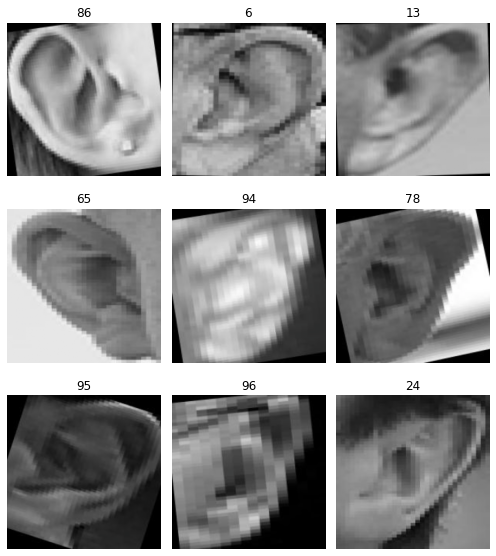

In [7]:
#take a peak at the batch to make sure things were loaded correctly
data.show_batch(rows=3, figsize=(7, 8))


# Set up fastai Resnet model

In [8]:
from fastai.metrics import error_rate # 1 - accuracy
learn = create_cnn(data, models.resnet152, metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [9]:
#print network layers
#learn

# Train Custom Resnet Image Classifier

In [10]:
from fastai.callbacks import *
early_stop = EarlyStoppingCallback(learn, patience=20)
save_best_model = SaveModelCallback(learn, name=model_name)

In [11]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)
    
    
    #loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #return the learning rate that produces the minimum loss divide by 10   
    return lrs[min_loss_index] / 10

In [12]:
defaults.device = torch.device('cuda') # makes sure the gpu is used
for i in range(repeats):
  print(f'----STEP {i}----\n\n')
  #frozen training step
  learn.fit_one_cycle(epochs, callbacks=[early_stop, save_best_model])
  #load best model from frozen training
  learn.load(model_name)
  learn.unfreeze()
  optimal_lr = find_appropriate_lr(learn)
  learn.fit_one_cycle(epochs, max_lr=slice(optimal_lr/10, optimal_lr), callbacks=[early_stop, save_best_model])
  learn.load(model_name)

----STEP 0----




epoch,train_loss,valid_loss,error_rate,time
0,6.172254,5.287804,0.975439,00:45
1,5.403044,4.356432,0.929825,00:44
2,4.555541,3.771821,0.821053,00:43
3,3.679679,3.374861,0.738596,00:43
4,2.852029,3.045804,0.675439,00:43
5,2.141261,2.685549,0.615789,00:43
6,1.557955,2.546286,0.568421,00:43
7,1.136507,2.358625,0.568421,00:43
8,0.852398,2.313960,0.528070,00:43
9,0.656762,2.129029,0.510526,00:43


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Better model found at epoch 0 with valid_loss value: 5.287803649902344.
Better model found at epoch 1 with valid_loss value: 4.35643196105957.
Better model found at epoch 2 with valid_loss value: 3.7718210220336914.
Better model found at epoch 3 with valid_loss value: 3.374861478805542.
Better model found at epoch 4 with valid_loss value: 3.045804262161255.
Better model found at epoch 5 with valid_loss value: 2.685549020767212.
Better model found at epoch 6 with valid_loss value: 2.546286106109619.
Better model found at epoch 7 with valid_loss value: 2.3586246967315674.
Better model found at epoch 8 with valid_loss value: 2.313959836959839.
Better model found at epoch 9 with valid_loss value: 2.129028558731079.
Better model found at epoch 12 with valid_loss value: 2.095046281814575.
Better model found at epoch 13 with valid_loss value: 2.0663254261016846.
Better model found at epoch 17 with valid_loss value: 2.0343191623687744.
Better model found at epoch 21 with valid_loss value: 2.03

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,time
0,0.008150,1.797265,0.331579,00:58
1,0.008396,1.795691,0.328070,00:58
2,0.007317,1.799075,0.333333,00:58
3,0.006933,1.799050,0.329825,00:58
4,0.006404,1.790397,0.331579,00:58
5,0.006286,1.800264,0.340351,00:58
6,0.005065,1.792023,0.331579,00:58
7,0.005298,1.789647,0.333333,00:58
8,0.006183,1.812112,0.329825,00:58
9,0.005883,1.796998,0.329825,00:58


Better model found at epoch 0 with valid_loss value: 1.797264814376831.
Better model found at epoch 1 with valid_loss value: 1.795690894126892.
Better model found at epoch 4 with valid_loss value: 1.7903966903686523.
Better model found at epoch 7 with valid_loss value: 1.7896465063095093.
Better model found at epoch 11 with valid_loss value: 1.7883623838424683.
Better model found at epoch 17 with valid_loss value: 1.7767235040664673.


epoch,train_loss,valid_loss,error_rate,time
0,0.008150,1.797265,0.331579,00:58
1,0.008396,1.795691,0.328070,00:58
2,0.007317,1.799075,0.333333,00:58
3,0.006933,1.799050,0.329825,00:58
4,0.006404,1.790397,0.331579,00:58
5,0.006286,1.800264,0.340351,00:58
6,0.005065,1.792023,0.331579,00:58
7,0.005298,1.789647,0.333333,00:58
8,0.006183,1.812112,0.329825,00:58
9,0.005883,1.796998,0.329825,00:58


Epoch 38: early stopping
----STEP 1----




epoch,train_loss,valid_loss,error_rate,time
0,0.013391,1.824521,0.336842,00:58
1,0.013626,2.016776,0.364912,00:58
2,0.051885,2.218748,0.407018,00:58
3,0.160513,2.211946,0.380702,00:58
4,0.276704,1.869791,0.356140,00:57
5,0.358749,1.990177,0.326316,00:58
6,0.378083,1.801311,0.338596,00:58
7,0.393237,2.013872,0.336842,00:58
8,0.435568,1.923308,0.370175,00:58
9,0.470180,1.588488,0.285965,00:58


Better model found at epoch 0 with valid_loss value: 1.8245211839675903.
Better model found at epoch 6 with valid_loss value: 1.8013108968734741.
Better model found at epoch 9 with valid_loss value: 1.5884875059127808.
Better model found at epoch 11 with valid_loss value: 1.478256106376648.
Better model found at epoch 15 with valid_loss value: 1.2750242948532104.
Better model found at epoch 18 with valid_loss value: 1.0416852235794067.
Better model found at epoch 19 with valid_loss value: 0.9212801456451416.
Better model found at epoch 30 with valid_loss value: 0.8705515265464783.
Better model found at epoch 31 with valid_loss value: 0.8147062659263611.
Better model found at epoch 32 with valid_loss value: 0.7081141471862793.
Better model found at epoch 33 with valid_loss value: 0.6198326945304871.
Better model found at epoch 35 with valid_loss value: 0.6181716918945312.
Better model found at epoch 36 with valid_loss value: 0.6000848412513733.
Better model found at epoch 37 with valid_

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,time
0,0.001555,0.582520,0.091228,00:58
1,0.001468,0.582256,0.087719,00:58
2,0.000816,0.600004,0.092982,00:58
3,0.000843,0.577128,0.085965,00:58
4,0.001203,0.583820,0.089474,00:58
5,0.000985,0.578333,0.084211,00:57
6,0.001042,0.599343,0.092982,00:58
7,0.000951,0.596474,0.094737,00:58
8,0.001006,0.584567,0.089474,00:58
9,0.000707,0.605697,0.094737,00:58


Better model found at epoch 0 with valid_loss value: 0.5825198888778687.
Better model found at epoch 1 with valid_loss value: 0.5822561383247375.
Better model found at epoch 3 with valid_loss value: 0.5771282315254211.
Better model found at epoch 11 with valid_loss value: 0.5770962238311768.
Better model found at epoch 14 with valid_loss value: 0.5751732587814331.
Epoch 35: early stopping


# Evaluate Classifier Performance

In [13]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix()


In [14]:
#interp.plot_top_losses(9, figsize=(15,15))


In [15]:
#run inference on test images
import glob
import pickle
from IPython.display import Image, display

model = learn.model
model = model.cuda()
#im_list = glob.glob(dataset_test.location + '//test/*/*.jpg')
im_list = glob.glob(dataset.location + '/test/*/*.jpg')
pred_list = []
y = []
for imageName in im_list:
    img_class = int(os.path.basename(os.path.dirname(imageName)))
    img = open_image(imageName)
    prediction = learn.predict(img)
    pred_list.append(prediction)
    y.append(img_class)
    #print(img_class)
    #print(prediction[0], prediction[1])
    #print(prediction[2])
    #s = np.argsort(prediction[2])
    #print(s[-1])
    #print(prediction[2][s[-1]])
    #print(learn.data.classes[int(s[-1])])
    #display(Image(filename=imageName))
    #print("\n")

In [16]:
def compute_rankX(pred_list, y, rank):
    count_all = 0
    count_correct = 0
    for prediction, label in zip(pred_list, y):
      s = np.argsort(prediction[2])
      internal_label = learn.data.classes.index(str(label))
      #print(s[len(s) - (rank):])
      if internal_label in s[len(s) - rank:]:
        count_correct += 1
      count_all += 1
    return count_correct / count_all * 100

In [17]:
print('Version:', version)
ranks = []
print('Num of classes:', len(learn.data.classes))
for rank in range(1, len(learn.data.classes) + 1):
  acc = compute_rankX(pred_list, y, rank)
  if rank == 1:
    print('Rank 1:', acc)
  ranks.append(acc)
with open(dataset.location + '/' + model_name + '.res', 'wb') as f:
  pickle.dump(ranks, f)

from google.colab import files
files.download(dataset.location + '/' + model_name + '.res')

Version: 3
Num of classes: 100
Rank 1: 88.58131487889274


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Save custom classification model for future use

In [19]:
from google.colab import files
files.download(dataset.location + '/models/' + model_name + '.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>